In [12]:
from HARK.distributions import Bernoulli, Lognormal, MeanOneLogNormal, Normal
from HARK.model import Control, DBlock, RBlock

from HARK.simulation.monte_carlo import MonteCarloSimulator

import math

In [13]:
consumption_block = DBlock(
    **{
        "name": "consumption",
        "shocks": {
            "theta": (Normal, {"mu" : 0, "sigma": "TranShkStd"}),
        },
        "dynamics": {
            "y": lambda y, rho, theta: y * rho + theta,
            "R" : Control(["a", "y"]),
            "w": lambda a, R, y: R * a + math.e ** y,
            "c": Control("w"), # constraint c < w - debt_limit
            "a": lambda w, c: w - c,
        },
        "reward": {
            "u": lambda c, CRRA: c ** (1 - CRRA) / (1 - CRRA),
            "d": lambda a, R: - a * R 
        },
    }
)

In [14]:
calibration = {
    "DiscFac": 0.96,
    "CRRA": 2.0,
    "rho" : 0.95,
    "R": 1.03, # will get overridden
    "TranShkStd": 0.1,
    "debt_limit" : -1
}

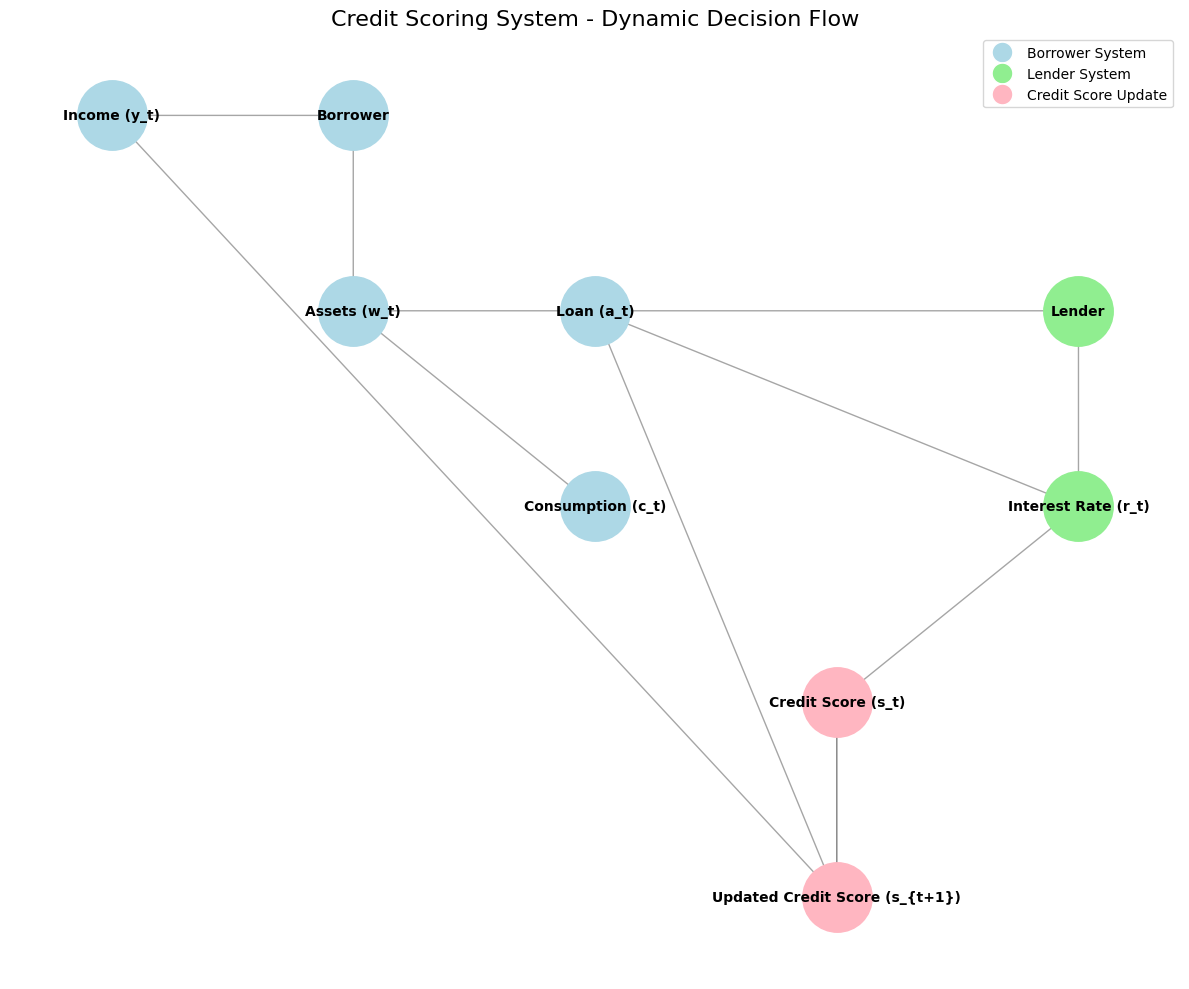

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create a directed graph
G = nx.DiGraph()

# Define nodes as a dictionary (node_id: label)
nodes = {
    'borrower': 'Borrower',
    'asset': 'Assets (w_t)',
    'income': 'Income (y_t)',
    'consumption': 'Consumption (c_t)',
    'loan': 'Loan (a_t)',
    'lender': 'Lender',
    'interest_rate': 'Interest Rate (r_t)',
    'credit_score': 'Credit Score (s_t)',
    'updated_score': 'Updated Credit Score (s_{t+1})'
}

# Define fixed positions for nodes (manually adjusted for clarity)
pos = {
    'borrower': (0, 3),
    'income': (-1, 3),
    'asset': (0, 2),
    'consumption': (1, 1),
    'loan': (1, 2),
    'lender': (3, 2),
    'interest_rate': (3, 1),
    'credit_score': (2, 0),
    'updated_score': (2, -1)
}

# Add nodes to the graph using the keys of the nodes dictionary
G.add_nodes_from(nodes.keys())

# Define edges as (source, target, relationship_label)
edges = [
    # Borrower decisions
    ('borrower', 'asset', 'Has wealth'),
    ('borrower', 'income', 'Earns income'),
    ('asset', 'consumption', 'Decides consumption'),
    ('asset', 'loan', 'Applies for loan'),
    
    # Lender process
    ('loan', 'lender', 'Loan request'),
    ('lender', 'interest_rate', 'Sets interest rate'),
    ('interest_rate', 'loan', 'Affects loan amount'),
    ('credit_score', 'interest_rate', 'Impacts interest rate'),
    
    # Credit score updates
    ('loan', 'updated_score', 'Impacts credit score'),
    ('income', 'updated_score', 'Impacts credit score'),
    ('credit_score', 'updated_score', 'Impacts future score'),
    ('updated_score', 'credit_score', 'Next period score')
]

# Add edges to the graph (ignoring the edge labels for drawing, they can be added separately if needed)
G.add_edges_from([(src, tgt) for src, tgt, label in edges])

# Define node groups for coloring (for clarity)
borrower_group = ['borrower', 'asset', 'income', 'consumption', 'loan']
lender_group = ['lender', 'interest_rate']
credit_group = ['credit_score', 'updated_score']

# Create a matplotlib figure
plt.figure(figsize=(12, 10))

# Draw nodes with different colors based on groups
nx.draw_networkx_nodes(G, pos, nodelist=borrower_group, node_color='lightblue', node_size=2500)
nx.draw_networkx_nodes(G, pos, nodelist=lender_group, node_color='lightgreen', node_size=2500)
nx.draw_networkx_nodes(G, pos, nodelist=credit_group, node_color='lightpink', node_size=2500)

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, alpha=0.7)

# Draw node labels using the provided nodes dictionary
nx.draw_networkx_labels(G, pos, labels=nodes, font_size=10, font_weight='bold')

# (Optional) Create a legend for the node groups
legend_elements = [
    mlines.Line2D([], [], marker='o', color='w', label='Borrower System',
                  markerfacecolor='lightblue', markersize=15),
    mlines.Line2D([], [], marker='o', color='w', label='Lender System',
                  markerfacecolor='lightgreen', markersize=15),
    mlines.Line2D([], [], marker='o', color='w', label='Credit Score Update',
                  markerfacecolor='lightpink', markersize=15)
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Add a title and remove axes for clarity
plt.title("Credit Scoring System - Dynamic Decision Flow", fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


## How to set $R$

Let `R = Control(a, y)` be the rule for how money is lent.

This is a simple that avoids the state explosion of history.
But since `y` is autoregressive that's fine.

We can look at the dynamics with different rules.

### Todo: test with a couple variations of rules and plot the outcomes.

In [39]:
sim = MonteCarloSimulator(  ### Use fm, blockified
    calibration,
    consumption_block,
    {
        "R": lambda a, y : 1.03,
        "c": lambda w: w,
    },
    {  # initial states
        "a": 1,
        "y": 1.0,
    },
    agent_count=3,
    T_sim=120,
)

sim.initialize_sim()
hist = sim.simulate()

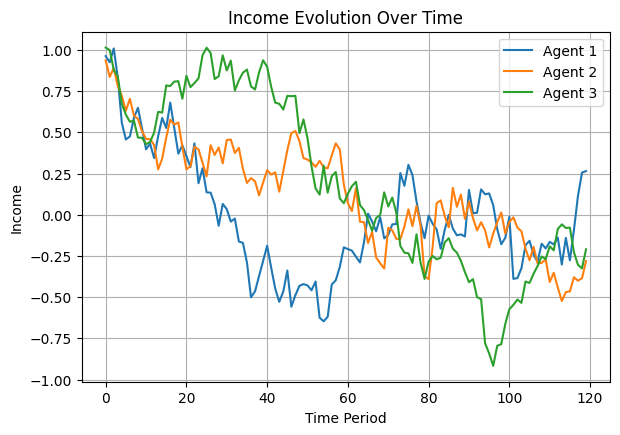

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 2)
for agent in range(sim.agent_count):
    plt.plot(hist['y'][:, agent], label=f'Agent {agent+1}')
plt.title('Income Evolution Over Time')
plt.xlabel('Time Period')
plt.ylabel('Income')
plt.legend()
plt.grid(True)
plt.show()

### Implement value backup on the two rewards, see if it reaches a steady state.

In [7]:
f = lambda a, b, c, d: a + b - c * d

In [8]:
args = {
    'a' : 1,
    'b': 2,
    'c' : 3,
    'd' : 4,
    'e' : 5
}

In [9]:
f(*args)

TypeError: <lambda>() takes 4 positional arguments but 5 were given